# Estimate Point Cloud From Depth Images 

## 1. Point cloud

A depth image (also called a depth map) is an image where each pixel provides its distance value relative to the sensor’s coordinate system. Depth images can be captured by structured light or time-of-flight sensors. To compute depth data, structured light sensors, such as Microsoft Kinect V1, compare the distortion between projected and received light. As for time-of-flight sensors like Microsoft Kinect V2, they project light rays and then compute the time elapsed between the projection and the reception of these later.

In addition to the depth image, some sensors provide their corresponding RGB image to form an RGB-D image. The latter makes it possible to compute a colored point cloud. We will use the Microsoft Kinect V1 RGB-D image as an example.

In [1]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
# Read depth image:
depth_image = iio.imread('figs/depth.png')

# print properties:
print(f"Image resolution: {depth_image.shape}")
print(f"Data type: {depth_image.dtype}")
print(f"Min value: {np.min(depth_image)}")
print(f"Max value: {np.max(depth_image)}")

Image resolution: (480, 640)
Data type: int32
Min value: 0
Max value: 2980


In [4]:
depth_intensity = np.array(256 * depth_image / 0x0fff, dtype=np.uint8)
iio.imwrite('figs/grayscale.png', depth_intensity)

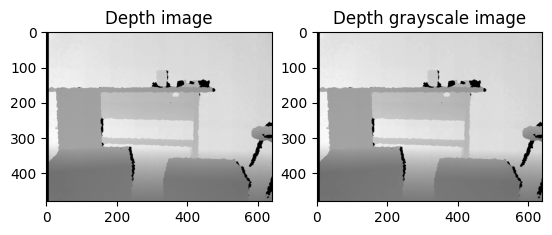

In [6]:
# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(depth_intensity, cmap="gray")
axs[1].set_title('Depth grayscale image')
plt.show()

## 2. Point Cloud

The first step is to calibrate the depth camera to estimate the camera matrix and then use it to compute the point cloud. The obtained point cloud is also called 2.5D point cloud since it is estimated from a 2D projection (depth image) instead of 3D sensors such as laser sensors.

### 2.1 Depth Camera Calibration

Calibrating a camera means estimating lens and sensor parameters by finding the distortion coefficients and the camera matrix also called the intrinsic parameters. In general, there are three methods for calibrating a camera : using the standard parameters provided by the factory, using the results obtained in calibration research or calibrating the Kinect manually. Calibrating the camera manually consists of applying one of the calibration algorithm such as the chess-board algorithm[1]. This algorithm is implemented in Robot Operating System (ROS) and OpenCV. The calibration matrix M is a 3×3 matrix:

<img src="figs/1_lizW_Umomcnp0xIklhuPlw.webp">

Where fx, fy and cx, cy are the focal length and the optical centers respectively. We will use the obtained results of NYU Depth V2 dataset:

In [7]:
# Depth camera parameters:
FX_DEPTH = 5.8262448167737955e+02
FY_DEPTH = 5.8269103270988637e+02
CX_DEPTH = 3.1304475870804731e+02
CY_DEPTH = 2.3844389626620386e+02

### 2.2 Point cloud computing

Computing point cloud here means transforming the depth pixel from the depth image 2D coordinate system to the depth camera 3D coordinate system (x, y and z). The 3D coordinates are computed using the following formulas [2], where depth(i, j) is the depth value at the row i and column j:

<img src="figs/1_ugq6ujIVstG3CKhdUu2JDA.webp">

The formula is applied for each pixel:

In [8]:
# compute point cloud:
pcd = []
height, width = depth_image.shape
for i in range(height):
   for j in range(width):
       z = depth_image[i][j]
       x = (j - CX_DEPTH) * z / FX_DEPTH
       y = (i - CY_DEPTH) * z / FY_DEPTH
       pcd.append([x, y, z])

In [9]:
pcd_o3d = o3d.geometry.PointCloud()  # create point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)  # set pcd_np as the point cloud points
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

## 3. Colored point cloud

The color information can enhance the performance of many tasks like point cloud registration. In this case, if the input sensor provides the RGB image too, it is preferable to use it. A colored point cloud can be defined as follows:

<img src="figs/1_p9PL_2rJ6jJQYKU98We2Kw.webp">

Where x, y and z are the 3D coordinates and r, g and b represent the color in the RGB system.

We start by importing the corresponding RGB image of the previous depth image:

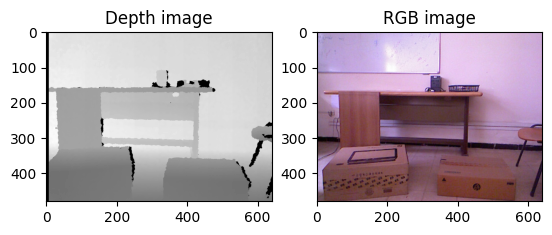

In [10]:
# Read the rgb image:
rgb_image = iio.imread('figs/rgb.jpg')

# Display depth and grayscale image:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(depth_image, cmap="gray")
axs[0].set_title('Depth image')
axs[1].imshow(rgb_image)
axs[1].set_title('RGB image')
plt.show()

To find the color of a given point p(x, y,z) that is defined in the depth sensor 3D coordinate system:

1. We transform it to the RGB camera coordinate system:

<img src="figs/1_0bvPnKERhmYkXAWtaBV3CA.webp">

Where R and T are the extrinsic parameters between the two cameras: the rotation matrix and the translation vector respectively.

Similarly, we use the parameters from NYU Depth V2 dataset:

In [11]:
# Rotation matrix:
R = -np.array([[9.9997798940829263e-01, 5.0518419386157446e-03, 4.3011152014118693e-03],
                   [-5.0359919480810989e-03, 9.9998051861143999e-01, -3.6879781309514218e-03],
                   [- 4.3196624923060242e-03, 3.6662365748484798e-03, 9.9998394948385538e-01]])
# Translation vector:
T = np.array([2.5031875059141302e-02, -2.9342312935846411e-04, 6.6238747008330102e-04])

The point in the RGB camera coordinate system is computed as follows:

In [12]:
"""
  Convert the point from depth sensor 3D coordinate system
  to rgb camera coordinate system:
"""
[x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

2. Using the intrinsic parameters of the RGB camera, we map it to color image coordinate system [2]:

<img src="figs/1_o-Ue6EQTLpuRmjlqVegMyw.webp">

These are the indices to get the color pixel.

Note that in the previous formulas, the focal length and the optical centers are the RGB camera parameters. Similarly, we use the parameters from NYU Depth V2 dataset:

In [13]:
# RGB camera intrinsic Parameters:
FX_RGB = 5.1885790117450188e+02
FY_RGB = 5.1946961112127485e+02
CX_RGB = 3.2558244941119034e+0
CY_RGB = 2.5373616633400465e+02

The indices of the corresponding pixel is computed as follows:

In [14]:
"""
  Convert from rgb camera coordinate system
  to rgb image coordinate system:
"""
j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

Let’s put all together and display the point cloud:

In [15]:
colors = []
pcd = []
for i in range(height):
    for j in range(width):
        """
            Convert the pixel from depth coordinate system
            to depth sensor 3D coordinate system
        """
        z = depth_image[i][j]
        x = (j - CX_DEPTH) * z / FX_DEPTH
        y = (i - CY_DEPTH) * z / FY_DEPTH

        """
            Convert the point from depth sensor 3D coordinate system
            to rgb camera coordinate system:
        """
        [x_RGB, y_RGB, z_RGB] = np.linalg.inv(R).dot([x, y, z]) - np.linalg.inv(R).dot(T)

        """
            Convert from rgb camera coordinates system
            to rgb image coordinates system:
        """
        j_rgb = int((x_RGB * FX_RGB) / z_RGB + CX_RGB + width / 2)
        i_rgb = int((y_RGB * FY_RGB) / z_RGB + CY_RGB)

        # Add point to point cloud:
        pcd.append([x, y, z])

        # Add the color of the pixel if it exists:
        if 0 <= j_rgb < width and 0 <= i_rgb < height:
            colors.append(rgb_image[i_rgb][j_rgb] / 255)
        else:
            colors.append([0., 0., 0.])
            
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

## 4. Code optimization

In this section, we explain how to optimize the code to be more efficient and suitable for real-time applications.

### 4.1 Point cloud

Computing point clouds using nested loops is time consuming. 

To reduce the computation time, nested loops can be replaced by vectorization operations.

In [18]:
# get depth resolution:
height, width = depth_image.shape
length = height * width
# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)
# rechape depth image
z = depth_image.reshape(length)
# compute pcd:
pcd = np.dstack([(ii - CX_DEPTH) * z / FX_DEPTH,
                 (jj - CY_DEPTH) * z / FY_DEPTH,
                 z]).reshape((length, 3))

We can also reduce the computation time by computing the constant once at the beginning:

In [19]:
# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)
# Compute constants:
xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH
# transform depth image to vector of z:
length = height * width
z = depth_image.reshape(height * width)
# compute point cloud
pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))

### 4.2 Colored point cloud

In [20]:
# compute indices:
jj = np.tile(range(width), height)
ii = np.repeat(range(height), width)

# Compute constants:
xx = (jj - CX_DEPTH) / FX_DEPTH
yy = (ii - CY_DEPTH) / FY_DEPTH

# transform depth image to vector of z:
length = height * width
z = depth_image.reshape(length)

# compute point cloud
pcd = np.dstack((xx * z, yy * z, z)).reshape((length, 3))
cam_RGB = np.apply_along_axis(np.linalg.inv(R).dot, 1, pcd) - np.linalg.inv(R).dot(T)
xx_rgb = ((cam_RGB[:, 0] * FX_RGB) / cam_RGB[:, 2] + CX_RGB + width / 2).astype(int).clip(0, width - 1)
yy_rgb = ((cam_RGB[:, 1] * FY_RGB) / cam_RGB[:, 2] + CY_RGB).astype(int).clip(0, height - 1)
colors = rgb_image[yy_rgb, xx_rgb]/255

In [21]:
# Convert to Open3D.PointCLoud:
pcd_o3d = o3d.geometry.PointCloud()  # create a point cloud object
pcd_o3d.points = o3d.utility.Vector3dVector(pcd)
pcd_o3d.colors = o3d.utility.Vector3dVector(colors)
# Visualize:
o3d.visualization.draw_geometries([pcd_o3d])

## References

* [Estimate Point Clouds From Depth Images in Python](https://betterprogramming.pub/point-cloud-computing-from-rgb-d-images-918414d57e80)